In [2]:
using PhyloNetworks
using PhyloPlots
using Combinatorics
using Formatting
using SparseArrays

In [8]:
trees = readMultiTopology("../../../data/rawdata/one.trees");
tree = trees[4]

HybridNetwork, Rooted Network
6 edges
7 nodes: 4 tips, 0 hybrid nodes, 3 internal tree nodes.
tip labels: 4, 1, 2, 3
(4:4.249,(1:2.457,(2:2.064,3:2.064):0.393):1.793);


In [3]:
[e.length for e in tree.edge]

6-element Vector{Float64}:
 4.249
 2.457
 2.064
 2.064
 0.393
 1.793

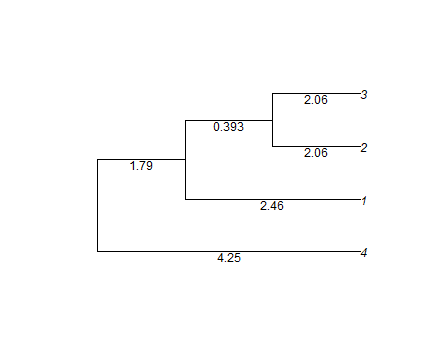

In [4]:
plot(tree, :R, showEdgeLength=true);

In [5]:
writeTopology(tree)

"(4:4.249,(1:2.457,(2:2.064,3:2.064):0.393):1.793);"

In [3]:
function num_bipartitions(n)
    return 2^(n-1) - 1
end;

In [4]:
function show_bipartitions(n::Int64; start::Int64 = 0, stop::Int64=-1)
    idx_width = length(string(num_bipartitions(n)))
    idx_fmt = FormatSpec(string(">", idx_width, "s"))
    node_width = length(string(n))
    node_fmt = FormatSpec(string(">", node_width, "s"))
    idx = 0
    node = Vector(1:n)
    println("idx\tpartition")
    for i in range(1, n÷2)
        
        comb = combinations(Vector(1:n), i)
        if i == n - i
            comb = Iterators.take(comb,  binomial(n,i)÷ 2)
        end
            
        for c in comb
            if start <= idx && (stop == -1 || idx <= stop)
                printfmt(idx_fmt, idx)
                print("\t")
                for e in c
                    printfmt(node_fmt, e)
                    print(" ")
                end
                print("| ")
                for e in sort(collect(setdiff(node ,Set(c))))
                    printfmt(node_fmt, e)
                    print(" ")
                end
                println()
            end
            idx += 1
        end
    end
end;

function show_bipartition(n, idx)
    show_bipartitions(n,start = idx,stop = idx)
end;

In [8]:
show_bipartitions(4)
show_bipartition(4, 3)

idx	partition
0	1 | 2 3 4 
1	2 | 1 3 4 
2	3 | 1 2 4 
3	4 | 1 2 3 
4	1 2 | 3 4 
5	1 3 | 2 4 
6	1 4 | 2 3 
idx	partition
3	4 | 1 2 3 


In [5]:
# get the nodes that the branch has. 
function get_taxa(encoded_taxa)
    nodes = []
    for i in 1:length(encoded_taxa)
        if encoded_taxa[i]
            append!(nodes, i)
        end
    end
    return nodes
end


function get_bipartition(tree::HybridNetwork, n::Int64)
    taxa = sort(tipLabels(tree))
    if length(taxa) != n
        print("check the parameter n")
        return
    end
    node = Vector(1:n)
    result = []
    idx = 0
    for i in tree.edge
        node_idx = hardwiredCluster(i,taxa)
        branch_node = get_taxa(node_idx)
        
        # if branch seperates more than half nodes, we use the small part to get bipartition idx
        if (length(branch_node) > n ÷ 2)
             branch_node = sort(collect(setdiff(node,branch_node)))
        end
        
        # generate all possible combination with the same number of nodes
        comb = collect(combinations(Vector(1:n), length(branch_node)))
        for c in 1:length(comb)
            if comb[c] == branch_node
                # if the combination is the later, we need to find its first half
                if length(branch_node) > 1 && c > length(comb) ÷ 2
                    c = length(comb) - c + 1 
                end
                idx = c - 1
                break
            end
        end
        for j in 1:(length(branch_node) - 1)
            idx = idx + binomial(n,j)
        end
        push!(result,Pair(idx, i.length))
        idx = 0
    end
    return result
end;

In [10]:
get_bipartition(tree, 4)

6-element Vector{Any}:
 3 => 4.249
 0 => 2.457
 1 => 2.064
 2 => 2.064
 6 => 0.393
 3 => 1.793

In [11]:
N = num_bipartitions(4)
data = zeros(1, N)
bipart = get_bipartition(tree, 4)
    for j in 1:length(bipart)
        data[1,(bipart[j][1] + 1)] += bipart[j][2]
    end
data

1×7 Matrix{Float64}:
 2.457  2.064  2.064  6.042  0.0  0.0  0.393

In [6]:
# trees is dataframe

function print_bipartition(trees::Vector{HybridNetwork}, n::Int64)
    
    # build the table
    N = num_bipartitions(n)
    data = zeros(length(trees), N)
    treeNum = 1;
    # get existing index
    
    for i in trees
        bipart = get_bipartition(i, n)
        for j in 1:length(bipart)
            data[treeNum,(bipart[j][1] + 1)] += bipart[j][2]
        end
        treeNum+=1
    end
    return data
end

print_bipartition (generic function with 1 method)

In [9]:
print_bipartition([tree], 4)

1×7 Matrix{Float64}:
 2.457  2.064  2.064  6.042  0.0  0.0  0.393

In [122]:
tree = readMultiTopology("../../../data/rawdata/one.trees")[1:3]
test = print_bipartition(tree, 4)

3×7 Matrix{Float64}:
 2.073  2.073  2.492  7.764  0.419  0.0  0.0
 1.084  1.084  2.035  6.046  0.95   0.0  0.0
 1.234  1.234  2.1    6.221  0.865  0.0  0.0

In [27]:
test = sparse(test)

3×7 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 2.073  2.073  2.492  7.764  0.419   ⋅    ⋅ 
 1.084  1.084  2.035  6.046  0.95    ⋅    ⋅ 
 1.234  1.234  2.1    6.221  0.865   ⋅    ⋅ 

In [202]:
using CSV, DataFrames

function print_csv(path, n, target)
    tree = readMultiTopology(path)
    result = print_bipartition(tree, n)
    N = num_bipartitions(n)
    header = Vector(0:N - 1)
    header = string.(header)
    CSV.write(target, DataFrame(result, :auto),header = header) 
end;

In [208]:
print_csv("data/rawdata/one.trees", 4, "data/one.csv");
print_csv("data/rawdata/two.trees", 4, "data/two.csv");

In [209]:
print_csv("data/rawdata/8_taxa_1.trees", 8, "data/8_one.csv");
print_csv("data/rawdata/8_taxa_2.trees", 8, "data/8_two.csv");

In [210]:
print_csv("data/rawdata/5_taxa_1.trees", 5, "data/5_one.csv");

In [6]:
function num_to_name(tree)
    taxa = sort(tipLabels(tree))
    dict = Dict{Int64, Any}()
    for i in 1:length(taxa)
        dict[i] = taxa[i]
    end
    return dict
end

num_to_name (generic function with 1 method)

In [7]:
trees = readMultiTopology("../../../data/rawdata/one.trees");
num_to_name(trees[1])

Dict{Int64, Any} with 4 entries:
  4 => "4"
  2 => "2"
  3 => "3"
  1 => "1"

In [8]:
trees = readMultiTopology("../../test/file/test.trees");
num_to_name(trees[1])

Dict{Int64, Any} with 4 entries:
  4 => "P2"
  2 => "O"
  3 => "P1"
  1 => "HYB"